# Обученме модели определения ключевых точек руки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import timm

import json
from glob import glob

import json
import cv2
import numpy as np
from glob import glob
import numpy as np
import cv2

from PIL import Image

from tqdm import tqdm

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
images_paths = glob("FreiHAND_pub_v2/training/rgb/*")[:32560]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

batch_size = 32

In [4]:
#For Training
def load_json_files(path = 'FreiHAND_pub_v2/'):
    with open(f'{path}/training_K.json') as K_fp, open(f'{path}/training_verts.json') as verts_fp, open(f'{path}/training_xyz.json') as xyz_fp:
        K_array = json.load(K_fp)
        verts_array = json.load(verts_fp)
        xyz_array = json.load(xyz_fp)
        
        return K_array, verts_array, xyz_array
    
def projectPoints(xyz, K):
    """ Project 3D coordinates into image space. """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

def renderPose(img, uv):
    connections = [[0,1], [1,2], [2,3], [3,4], 
                   [0,5], [5,6], [6,7], [7,8], 
                   [0,9], [9,10],[10,11], [11,12],
                   [0,13],[13,14], [14,15], [15,16], 
                   [0,17],[17,18], [18,19], [19,20]]
    for c in connections:
        img = cv2.line(img,uv[c[0]],uv[c[1]],(255,0,0),2)
        
    for point in uv:
        img = cv2.circle(img, point, 2, (0,0,255), -1)
        
    return img

In [5]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

In [6]:
K_array, verts_array, xyz_array = load_json_files()

In [7]:
keypoints = []
for index, image_path in enumerate(tqdm(images_paths)):
    # Read image from path
    image_arr = cv2.imread(image_path)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)

    # Geting dots coordinates
    image_height, image_width, _ = image_arr.shape
    uv = projectPoints(xyz_array[index], K_array[index]).astype(np.int32)

    # Convert to relative coordinates
    relative_points = [[x / image_width, y / image_height] for x, y in uv]
    keypoints.append(relative_points)

100%|██████████| 32560/32560 [05:10<00:00, 104.91it/s]


In [8]:
keypoints = [kp[8] for kp in keypoints]

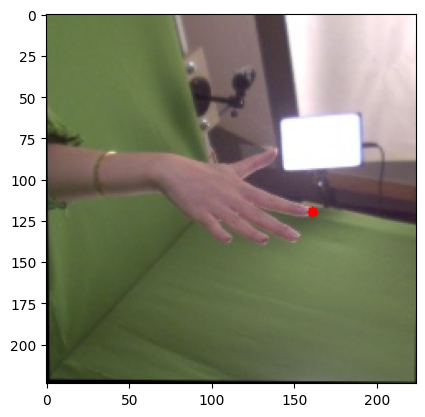

In [9]:
idx = 1

image = cv2.imread(images_paths[idx])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

x, y = keypoints[idx]
x *= w
y *= h

cv2.circle(image, (int(x), int(y)), 0, (255, 0, 0), 6)
plt.imshow(image)

In [10]:
train_idx, val_idx = [int(i) for i in [len(images_paths) * .7, len(images_paths) * .9]]

In [11]:
data = [(i, k) for i, k in zip(images_paths, keypoints)]

In [12]:
dataset = {"train": data[:train_idx], "val": data[train_idx:val_idx], "test": data[val_idx:]}

In [13]:
class KeypointsDataset(Dataset):

    def __init__(self, meta):
        self.meta = meta
        self.preprocessing = A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name, relative_points = self.meta[idx]
        image = self.preprocessing(image=image_arr)['image']
        x, y = relative_points
        return image, torch.Tensor([x, y])

In [14]:
train_dataset = KeypointsDataset(meta=dataset["train"])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [15]:
val_dataset = KeypointsDataset(meta=dataset["val"])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [16]:
# model = timm.create_model('mobilenetv2_050', pretrained=True, num_classes=0)
# model.global_pool = nn.Flatten()
# model.classifier = nn.Sequential(
#     nn.Linear(62720, 2),
#     nn.Sigmoid()
# )
# model.to(device);

In [17]:
# Возьмем предобученную модель и перепишем классификатор 
model_name = 'tf_efficientnetv2_s_in21k'
model = timm.create_model(model_name, pretrained=True).to("cuda")

model
additional_layers = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU()
)
model.classifier = nn.Sequential(
    nn.Linear(256, 2)
)

model.classifier = nn.Sequential(additional_layers, model.classifier)
_ = model.to("cuda")

/home/germa/miniconda3/envs/hand/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


In [18]:
EPOCHS = 100
lr = 0.001

optimizer = optim.AdamW(model.parameters(), lr)

criterion = nn.MSELoss()

In [ ]:
for epoch in range(EPOCHS):
    
    model.train()
        
    train_loss = []
    train_predictions = []
    train_targets = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        
        batch = batch.to(device)
        targets = targets.to(device)
        
        predictions = model(batch)
        
        loss = criterion(predictions, targets) 
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        
        predictions = predictions.cpu().detach().numpy()
        train_predictions.extend(predictions)
        targets = targets.cpu().detach().numpy()
        train_targets.extend(targets)
    
    train_targets = np.array(train_targets)
    train_predictions = np.array(train_predictions)
    print('Training loss:', np.mean(train_loss))
    print('Train OKS:', oks(train_targets, train_predictions, train_targets))
    
    model.eval()
        
    val_predictions = []
    val_targets = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        
        with torch.no_grad():
        
            batch = batch.to(device)
            targets = targets.to(device)
            predictions = model(batch)
            
            predictions = predictions.cpu().numpy()
            val_predictions.extend(predictions)
            targets = targets.cpu().numpy()
            val_targets.extend(targets)
        
    val_targets = np.array(val_targets)
    val_predictions = np.array(val_predictions)
    print('Val OKS:', oks(val_targets, val_predictions, val_targets))

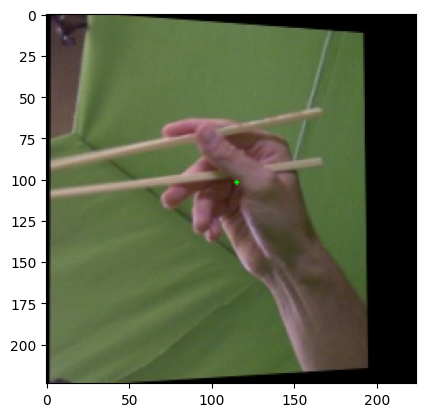

In [33]:
val_id = 4
image_name, relative_points = dataset["test"][val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

height, width, _ = image.shape

points = pred.reshape(-1, 2)

for x, y in points:
    x = int(x * width)
    y = int(y * height)
    cv2.circle(image, (x, y), 0, (0, 255, 0), 2)
plt.imshow(image)

In [32]:
pred

array([0.51707685, 0.45932737], dtype=float32)

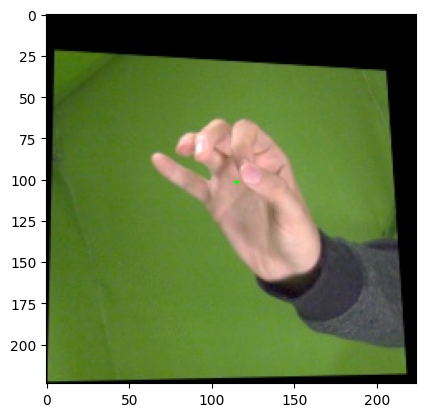

In [31]:
val_id = 2
image_name, relative_points = dataset["test"][val_id]
image = Image.open(image_name).convert('RGB')
image = np.asarray(image)
pred = model(train_dataset.preprocessing(image=image)['image'].unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy()[0]

height, width, _ = image.shape

points = pred.reshape(-1, 2)

for x, y in points:
    x = int(x * width)
    y = int(y * height)
    cv2.circle(image, (x, y), 0, (0, 255, 0), 2)
plt.imshow(image)

# Сравнение с другими моделями

In [35]:
test_dataset = KeypointsDataset(meta=dataset["test"])
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [38]:
model.eval()
        
val_predictions = []
val_targets = []
for batch, targets in tqdm(test_dataloader):

    with torch.no_grad():

        batch = batch.to(device)
        targets = targets.to(device)
        predictions = model(batch)

        predictions = predictions.cpu().numpy()
        val_predictions.extend(predictions)
        targets = targets.cpu().numpy()
        val_targets.extend(targets)

val_targets.append(val_targets)
val_predictions.append(val_predictions)

100%|██████████| 204/204 [00:14<00:00, 14.30it/s]


In [39]:
val_targets = [list(i) for i in val_targets]

In [40]:
val_targets = [x for y in val_targets for x in y]

In [41]:
val_predictions = [list(i) for i in val_predictions]
val_predictions = [x for y in val_predictions for x in y]

In [42]:
val_predictions = val_predictions[:200000]
val_targets = val_targets[:200000]

## Метрика -- MSE

In [43]:
from sklearn.metrics import mean_squared_error

In [50]:
mse_own_model = mean_squared_error(val_targets, val_predictions)

In [51]:
import mediapipe as mp

In [52]:
mp_model = mp.solutions.hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [54]:
true_values, mediapipe_preds = [], []
for im_path, points in tqdm(dataset["test"]):
    
    image = cv2.imread(im_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_AREA)
    results = mp_model.process(image_rgb)
    if results.multi_hand_landmarks:
        results_xy = []
        for hand_landmarks in results.multi_hand_landmarks:
            for landmark in hand_landmarks.landmark:
                results_xy.append(landmark.x)
                results_xy.append(landmark.y)
        mediapipe_preds.append(results_xy)
        
        y_true = points
        true_values.append(y_true)

100%|██████████| 3256/3256 [01:42<00:00, 31.78it/s]


In [72]:
tr = [x for y in true_values for x in y]

In [73]:
pr = [x for y in mediapipe_preds for x in y]

In [57]:
mediapipe_MSE = mean_squared_error(tr, pr)

In [74]:
print(f"MSE нашей модели: {mse_own_model:.4f}")
print(f"MSE mediapipe: {mediapipe_MSE:.4f}")

MSE нашей модели: 0.0081
MSE mediapipe: 0.0033


Такие дела...